In [62]:
import os

if 'main_dir' in globals():
    os.chdir(main_dir)

import pandas as pd
from utils.load_config import load_exp_config, get_value_from_fields, get_df_historical_data
import matplotlib
%matplotlib inline

from regelum.objective import RunningObjective
from regelum.model import ModelQuadLin
import numpy as np


if os.getcwd().endswith("notebooks"):
    main_dir = os.getcwd()
    os.chdir("..")

In [63]:

objective_function = RunningObjective(ModelQuadLin(
    weights= [2, 10, 0, 0, 0],
    quad_matrix_type="diagonal",
    is_with_linear_terms=False,
))

def get_sampling_time(exp_path):
    config = load_exp_config(exp_path)

    sampling_time = config['scenario']['sampling_time']
    if "$" in sampling_time:
        correct_fields = sampling_time.strip("\{\}$").split(".")
        sampling_time = get_value_from_fields(config, correct_fields)

    return sampling_time

def cal_obj_df(row):
    observation = np.expand_dims(np.array(row.loc[["x [m]", "y [m]", "angle [rad]"]].values), axis=0)
    action = np.expand_dims(np.array(row.loc[["velocity [m/s]", "angular velocity [rad/s]"]].values), axis=0)
    
    return objective_function(observation, action)

In [64]:
class ExperimentData():
    def __init__(self, exp_path, chosen_name) -> None:
        self.df = get_df_historical_data(exp_path, chosen_name)
        self.sampling_time = get_sampling_time(exp_path)
        
        self.correct_column_name()
        self.calculate_objective_values()

    def correct_column_name(self):
        replacements = {
            "x_rob"   :     "x [m]", 
            "y_rob"   :    "y [m]",
            "vartheta":       "angle [rad]",
            "v"       : "velocity [m/s]",
            "omega"   :    "angular velocity [rad/s]",
        }

        new_columns = []
        if "x [m]" not in self.df.columns.values:
            for col in self.df.columns.values:
                new_columns.append(col if col not in replacements else replacements[col])

            self.df.columns = new_columns

    def calculate_objective_values(self):
        self.df["objective_value"] = self.df.apply(cal_obj_df, axis=1)
        self.df["accumulative_objective"] = self.df["objective_value"].apply(lambda x: x*self.sampling_time).cumsum()

    def plot_cost(self, ax, exp_name=""):
        ax.set_title("{} - final cost: {:0.2f}".format(exp_name, self.df.accumulative_objective.max()))
        self.df.plot(x="time", y="accumulative_objective", ax=ax)
        self.df.plot(x="time", y="objective_value", ax=ax)
        ax.grid()

    def plot_trajectory(self, ax, exp_name=""):
        ax.set_title("Trajectory")
        ax.plot(self.df["x [m]"], self.df["y [m]"], label=exp_name)
        ax.grid()
    

In [65]:
exp_path="/home/robosrv/huyhoang/regelum-playground/regelum_data/outputs/2024-08-20/14-38-30/0"
chosen_name="observations_actions_it_00001"
ppo_exp = ExperimentData(exp_path, chosen_name)

ref_exp_path="/home/robosrv/huyhoang/regelum-playground/regelum_data/outputs/2024-08-20/14-45-59/0"
ref_chosen_name="observations_actions_it_00001"
nominal_exp = ExperimentData(ref_exp_path, ref_chosen_name)

## Get sampling time

In [66]:
sampling_time = get_sampling_time(exp_path)
ref_sampling_time = get_sampling_time(ref_exp_path)

## Re-calculate objective

### Define objective function

In [67]:

observation = np.array([[1, 1, 0.01]])
actions = np.array([[1, 1]])
objective_function(observation, actions)

12.0

### Calculate Objective

## Plot objective

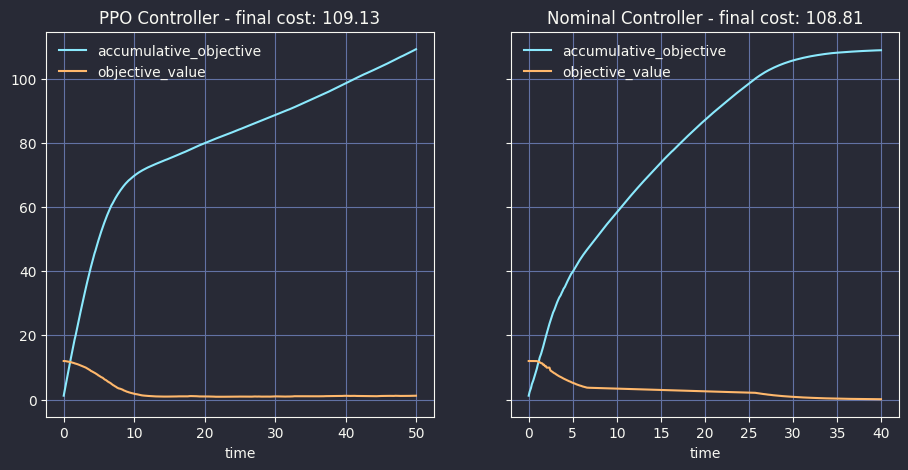

In [68]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 2, figsize=(11, 5), sharey=True)
ppo_exp.plot_cost(ax[0], "PPO Controller")
nominal_exp.plot_cost(ax[1], "Nominal Controller")

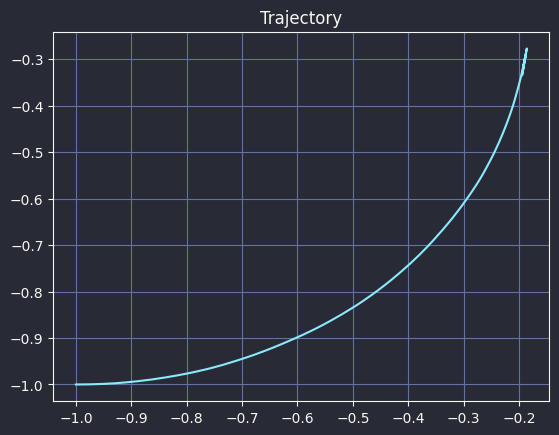

In [70]:

fig, ax = plt.subplots()
ppo_exp.plot_trajectory(ax)